In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from importlib import import_module
import util
import seaborn

In [2]:
arch_name = "netdlem2"

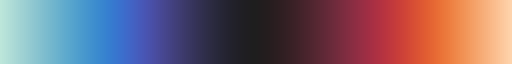

In [3]:
seaborn.color_palette("icefire", as_cmap=True)

In [4]:
dev = torch.device('cuda')

In [5]:
patch = np.log(np.load("patch.npy"))
#patch = np.mean(einops.rearrange(patch, "(w wb) (h hb) -> w h (wb hb)", wb=20, hb=20), axis=(-1))

In [6]:
patch = util.tile_patch(patch, kernel_size=10)

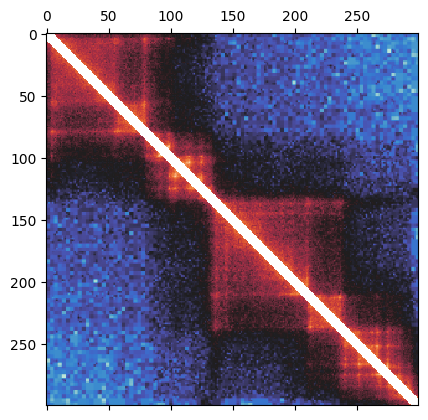

In [7]:
plt.matshow(util.ignore_diag_plot(patch, 5), cmap='icefire')

In [8]:
patch = util.diagonal_normalize(patch)

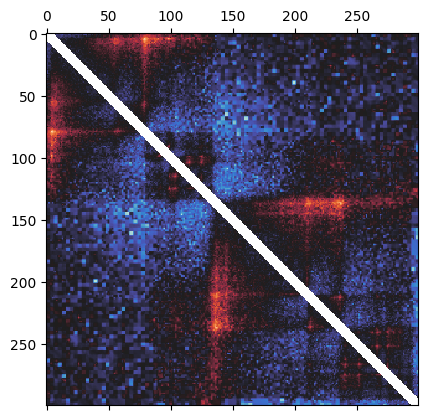

In [9]:
plt.matshow(util.ignore_diag_plot(patch, 5), cmap='icefire')

In [10]:
architecture = getattr(import_module(f"models.{arch_name}"), "DLEM")
model = architecture(np.ones(patch.shape[0]) * 0.95, np.ones(patch.shape[0]) * 0.95)#, free_unload=True)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.5)

In [12]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, mode="max")

In [13]:
diag_stop = int(np.floor(patch.shape[0]*0.3)) #we don't get much information from the corner anyway

In [14]:
def weighted_mse_loss(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)
loss = torch.nn.MSELoss(reduction='sum')
loss = weighted_mse_loss

In [15]:
best_loss_model, best_corr_model, arr_loss, arr_corr = util.train(model, optimizer, scheduler, loss, np.exp(patch), 3, diag_stop, dev, num_epoch=250)

Text(0, 0.5, 'correlation')

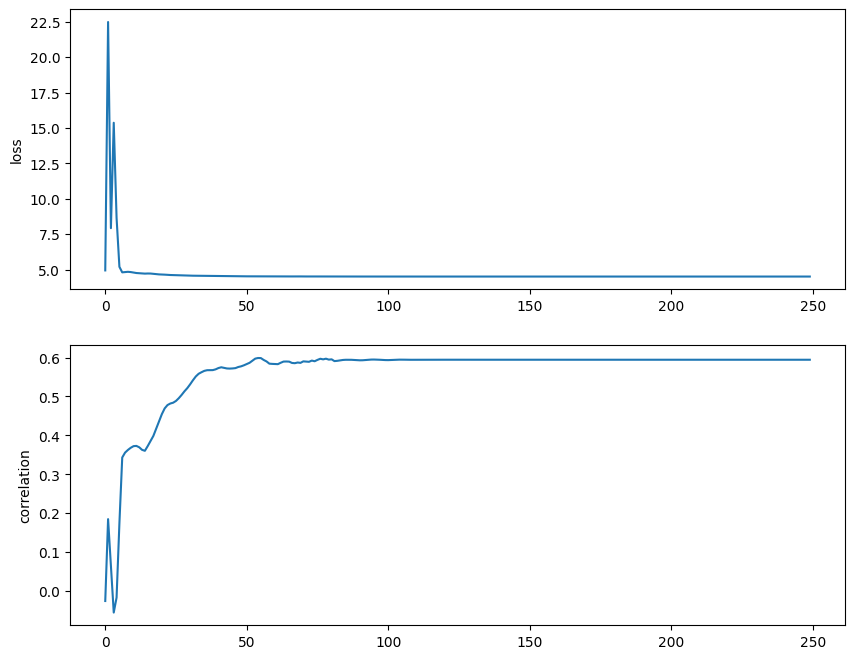

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(arr_loss)
axes[0].set_ylabel("loss")
axes[1].plot(arr_corr)
axes[1].set_ylabel("correlation")

In [17]:
best_loss_pred = best_loss_model.contact_map_prediction(torch.ones(patch.shape[0], device=dev) * patch.shape[0]).detach().cpu().numpy()
best_loss_pred = util.diagonal_normalize(np.log(best_loss_pred))
best_corr_pred = best_corr_model.contact_map_prediction(torch.ones(patch.shape[0], device=dev) * patch.shape[0]).detach().cpu().numpy()
best_corr_pred = util.diagonal_normalize(np.log(best_corr_pred))

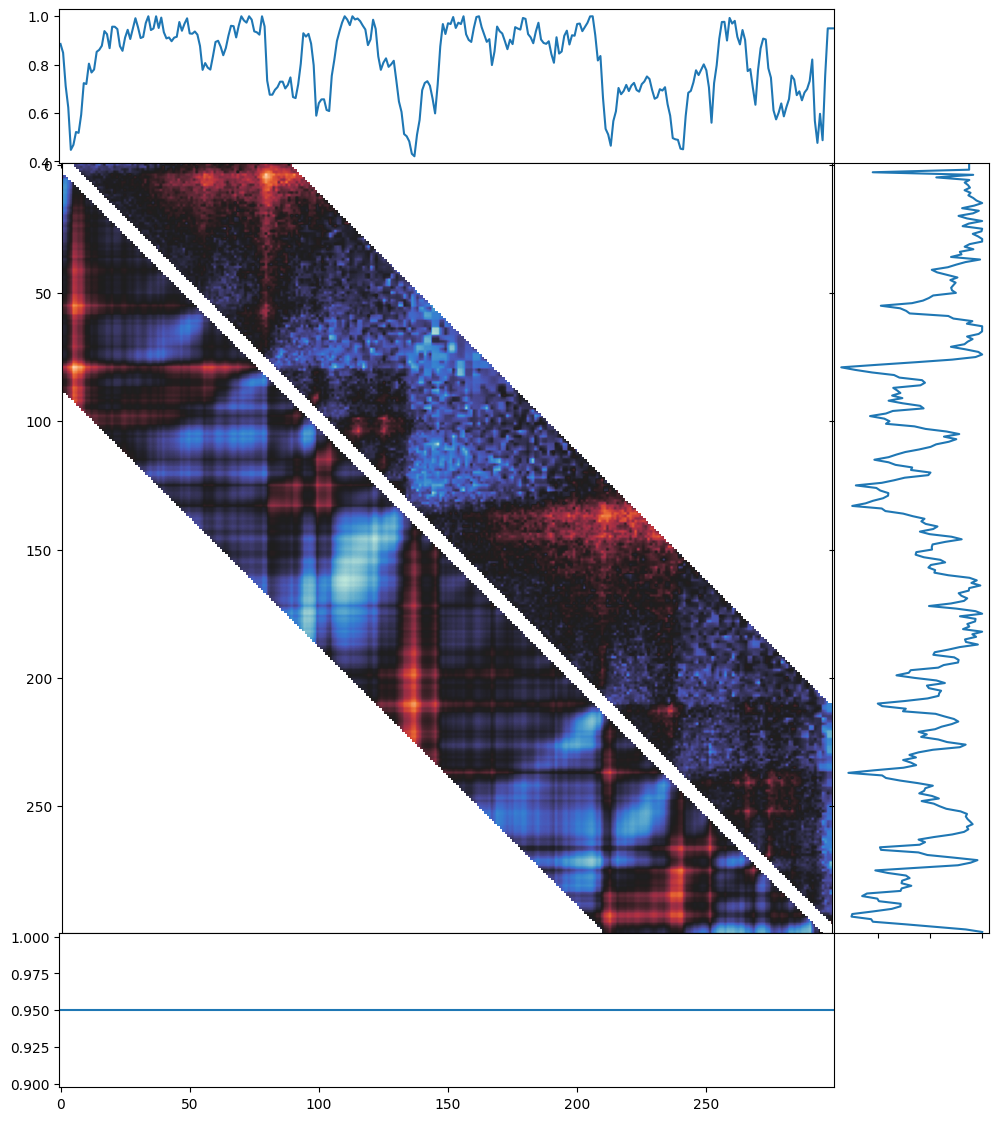

In [18]:
util.plot_results(patch, best_loss_pred, best_loss_model.return_parameters())

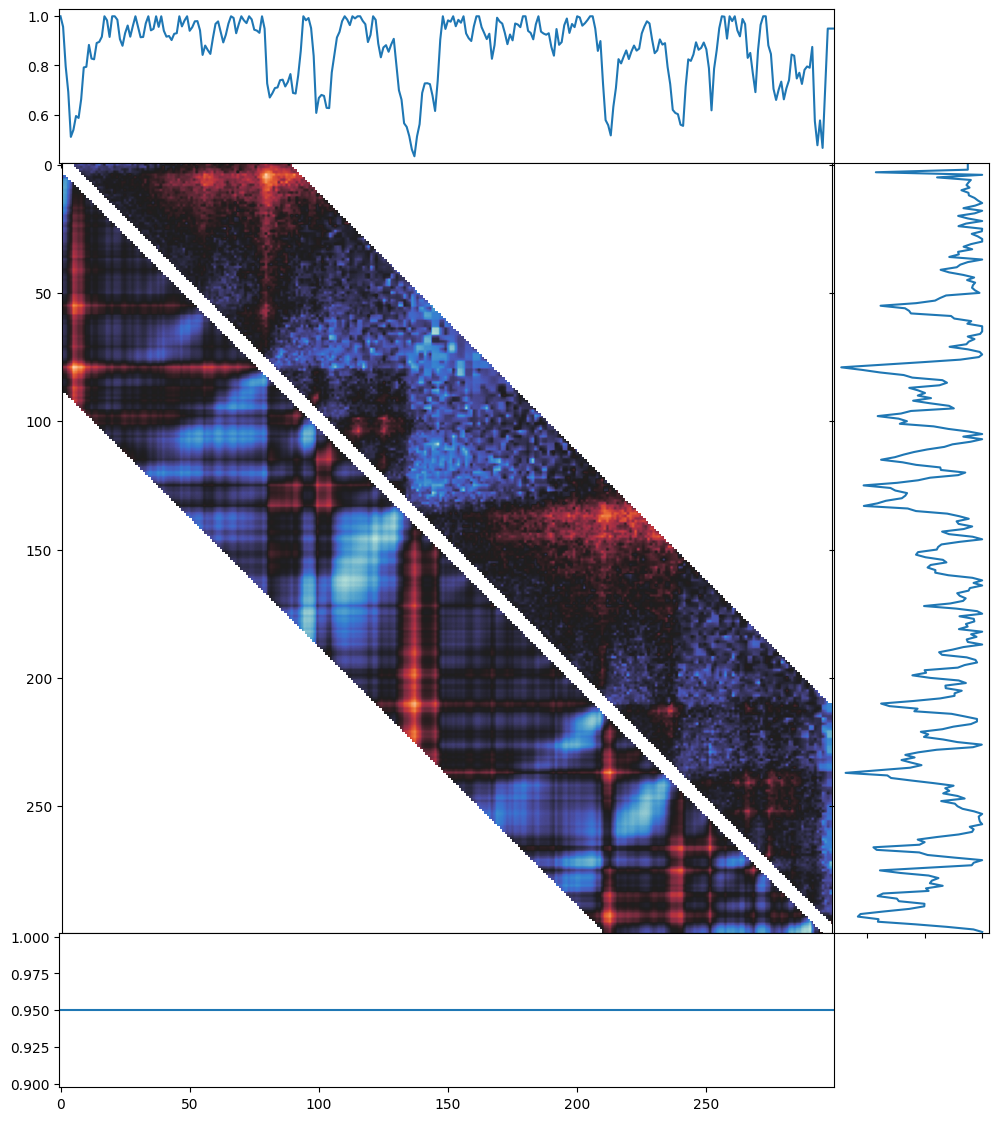

In [19]:
util.plot_results(patch, best_corr_pred, best_corr_model.return_parameters())